# OFI Analysis

This notebook will handle the analysis of Order-Flow Imbalance (OFI).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Load the data
data = pd.read_csv('../data/outputs/hawkes_modeling_data.csv')

In [2]:
data.head()

,record_type,segment,trade_number,symbol,series,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
0,RM,CASH,2019081325008066,bbbbbbINFY,EQ,785.0,1,1100000000068964,1,2,1100000000062580,1,3,2019-08-13 09:15:00.006118774,2019-08-13 09:15:00.005767822,NaN,-1,2019-08-13
1,RM,CASH,2019081325008128,bbbbbbINFY,EQ,785.0,2,1100000000069441,1,3,1100000000062580,1,3,2019-08-13 09:15:00.024169922,2019-08-13 09:15:00.024139404,NaN,-1,2019-08-13
2,RM,CASH,2019081325008129,bbbbbbINFY,EQ,785.0,47,1100000000069442,1,3,1100000000062580,1,3,2019-08-13 09:15:00.024230957,2019-08-13 09:15:00.024215698,NaN,-1,2019-08-13
3,RM,CASH,2019081325008130,bbbbbbINFY,EQ,785.0,53,1100000000069442,1,3,1100000000068983,0,3,2019-08-13 09:15:00.024246216,2019-08-13 09:15:00.024215698,2019-08-13 09:15:00.005935669,1,2019-08-13
4,RM,CASH,2019081325008466,bbbbbbINFY,EQ,785.0,10,1100000000055032,1,3,1100000000070554,0,1,2019-08-13 09:15:00.118347168,NaN,2019-08-13 09:15:00.118331909,1,2019-08-13


In [3]:
data.drop(['series', 'symbol', 'segment', 'record_type' ], axis=1, inplace=True)

In [35]:
data.columns

Index(['trade_number', 'trade_price', 'volume', 'buy_order_number', 'buy_algo',
       'buy_client', 'sell_order_number', 'sell_algo', 'sell_client',
       'timestamp', 'buy_entry_ts', 'sell_entry_ts', 'aggressor_side', 'date'],
      dtype='object')

In [4]:
data.describe(include='all')

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
count,1.362358e+06,1.362358e+06,1.362358e+06,1.362358e+06,1.362358e+06,1.362358e+06,1.362358e+06,1.362358e+06,1.362358e+06,1362358,1360695,1360279,1.362358e+06,1362358
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1362358,477269,434603,NaN,9
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-13 09:15:00.006118774,2019-08-20 10:24:59.485458374,2019-08-13 15:15:00.468292236,NaN,2019-08-27
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,544,501,NaN,241614
mean,2.019082e+15,7.857527e+02,4.647522e+01,1.100000e+15,3.922251e-01,1.870199e+00,1.100000e+15,3.432343e-01,1.704632e+00,NaN,NaN,NaN,3.419072e-03,NaN
std,4.932625e+08,1.125683e+01,2.644905e+02,2.215966e+06,5.733828e-01,9.278427e-01,2.220860e+06,5.098775e-01,8.820939e-01,NaN,NaN,NaN,9.999784e-01,NaN
min,2.019081e+15,7.601500e+02,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,NaN,NaN,NaN,-1.000000e+00,NaN
25%,2.019082e+15,7.750000e+02,3.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,NaN,NaN,NaN,-1.000000e+00,NaN
50%,2.019082e+15,7.852500e+02,1.000000e+01,1.100000e+15,0.000000e+00,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,NaN,NaN,NaN,1.000000e+00,NaN
75%,2.019083e+15,7.968500e+02,3.600000e+01,1.100000e+15,1.000000e+00,3.000000e+00,1.100000e+15,1.000000e+00,3.000000e+00,NaN,NaN,NaN,1.000000e+00,NaN


In [ ]:
from aggressor_tests import validate_aggressor_logic

results, rule_1_failures, rule_2_failures, fail_agg1, fail_not_agg1 = validate_aggressor_logic(data)

Running Aggressor Logic Tests...
Rule 1 Failed for 12 rows (Sell Entry NaN).
Rule 2 Failed for 12 rows (Buy Entry NaN).
Rule 3 Failed for 32 rows (Both entries present).
Test Complete.


In [9]:
rule_1_failures

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
688787,2019082125005856,794.35,30,1100000000005130,1,3,1100000000004881,1,3,2019-08-21 09:15:03.511978149,NaT,NaT,0,2019-08-21
843290,2019082225004613,799.90,50,1100000000054011,1,3,1100000000059412,1,2,2019-08-22 09:15:00.413955688,NaT,NaT,0,2019-08-22
979820,2019082625019280,790.00,20,1100000000038463,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416305542,NaT,NaT,0,2019-08-26
979821,2019082625019281,790.00,10,1100000000040417,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416320801,NaT,NaT,0,2019-08-26
979822,2019082625019282,790.00,729,1100000000038163,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416336060,NaT,NaT,0,2019-08-26
979823,2019082625019283,790.00,2,1100000000046948,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416351318,NaT,NaT,0,2019-08-26
979824,2019082625019284,790.00,30,1100000000049568,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416366577,NaT,NaT,0,2019-08-26
979825,2019082625019285,790.00,30,1100000000049915,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416381836,NaT,NaT,0,2019-08-26
979826,2019082625019286,790.00,1,1100000000051149,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416397095,NaT,NaT,0,2019-08-26
979827,2019082625019287,790.00,1,1100000000051160,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416412354,NaT,NaT,0,2019-08-26


In [62]:
order_26 = pd.read_csv(r'c:\Users\Irfan\Hawkes_Modeling\data\outputs\orders\INFY_orders_26082019.csv')

In [23]:
order_26.head()

,record_type,segment,order_number,side,activity_type,symbol,series,volume_disclosed,volume,limit_price,trigger_price,is_market_order,is_stop_loss,is_ioc,algo_indicator,client_type,timestamp,is_buy
0,RM,CASH,1100000000072550,SELL,ENTRY,bbbbbbINFY,EQ,0,100,795.00,0.0,False,N,False,1,2,2019-08-26 09:15:00.005050659,False
1,RM,CASH,1100000000072563,BUY,ENTRY,bbbbbbINFY,EQ,0,300,792.55,0.0,False,N,False,1,3,2019-08-26 09:15:00.005249023,True
2,RM,CASH,1100000000072581,SELL,ENTRY,bbbbbbINFY,EQ,0,128,802.15,0.0,False,N,False,1,3,2019-08-26 09:15:00.005462646,False
3,RM,CASH,1100000000072598,SELL,ENTRY,bbbbbbINFY,EQ,357,357,795.90,0.0,False,N,False,0,3,2019-08-26 09:15:00.005599976,False
4,RM,CASH,1100000000072629,BUY,ENTRY,bbbbbbINFY,EQ,1,1,792.00,0.0,False,N,False,1,2,2019-08-26 09:15:00.005844116,True


In [ ]:
{s:1100000000066040, b: 1100000000038463}

In [24]:
order_26['order_number'].dtype

dtype('int64')

In [28]:
1100000000072550 in list(order_26['order_number'])

True

In [31]:
1100000000066040 in list(order_26['order_number']), 1100000000038463 in list(order_26['order_number'])

(True, False)

In [34]:
1100000000038163 in list(order_26['order_number'])

False

In [30]:
list(order_26['order_number']).index(1100000000066040)

154

In [32]:
order_26.iloc[154]

record_type                                    RM
segment                                      CASH
order_number                     1100000000066040
side                                         SELL
activity_type                              MODIFY
symbol                                 bbbbbbINFY
series                                         EQ
volume_disclosed                                0
volume                                       4182
limit_price                                 795.8
trigger_price                                 0.0
is_market_order                             False
is_stop_loss                                    N
is_ioc                                      False
algo_indicator                                  0
client_type                                     1
timestamp           2019-08-26 09:15:00.340637207
is_buy                                      False
Name: 154, dtype: object

In [11]:
rule_2_failures

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
688787,2019082125005856,794.35,30,1100000000005130,1,3,1100000000004881,1,3,2019-08-21 09:15:03.511978149,NaT,NaT,0,2019-08-21
843290,2019082225004613,799.90,50,1100000000054011,1,3,1100000000059412,1,2,2019-08-22 09:15:00.413955688,NaT,NaT,0,2019-08-22
979820,2019082625019280,790.00,20,1100000000038463,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416305542,NaT,NaT,0,2019-08-26
979821,2019082625019281,790.00,10,1100000000040417,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416320801,NaT,NaT,0,2019-08-26
979822,2019082625019282,790.00,729,1100000000038163,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416336060,NaT,NaT,0,2019-08-26
979823,2019082625019283,790.00,2,1100000000046948,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416351318,NaT,NaT,0,2019-08-26
979824,2019082625019284,790.00,30,1100000000049568,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416366577,NaT,NaT,0,2019-08-26
979825,2019082625019285,790.00,30,1100000000049915,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416381836,NaT,NaT,0,2019-08-26
979826,2019082625019286,790.00,1,1100000000051149,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416397095,NaT,NaT,0,2019-08-26
979827,2019082625019287,790.00,1,1100000000051160,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416412354,NaT,NaT,0,2019-08-26


In [12]:
rule_2_failures

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
688787,2019082125005856,794.35,30,1100000000005130,1,3,1100000000004881,1,3,2019-08-21 09:15:03.511978149,NaT,NaT,0,2019-08-21
843290,2019082225004613,799.90,50,1100000000054011,1,3,1100000000059412,1,2,2019-08-22 09:15:00.413955688,NaT,NaT,0,2019-08-22
979820,2019082625019280,790.00,20,1100000000038463,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416305542,NaT,NaT,0,2019-08-26
979821,2019082625019281,790.00,10,1100000000040417,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416320801,NaT,NaT,0,2019-08-26
979822,2019082625019282,790.00,729,1100000000038163,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416336060,NaT,NaT,0,2019-08-26
979823,2019082625019283,790.00,2,1100000000046948,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416351318,NaT,NaT,0,2019-08-26
979824,2019082625019284,790.00,30,1100000000049568,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416366577,NaT,NaT,0,2019-08-26
979825,2019082625019285,790.00,30,1100000000049915,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416381836,NaT,NaT,0,2019-08-26
979826,2019082625019286,790.00,1,1100000000051149,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416397095,NaT,NaT,0,2019-08-26
979827,2019082625019287,790.00,1,1100000000051160,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416412354,NaT,NaT,0,2019-08-26


In [13]:
fail_agg1

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date


In [14]:
fail_not_agg1

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
15655,2019081325339503,773.70,8,1100000000797598,0,3,1100000000797599,0,2,2019-08-13 09:29:21.718353271,2019-08-13 09:29:21.711761475,2019-08-13 09:29:21.711761475,0,2019-08-13
63167,2019081326354825,770.05,21,1100000002783718,0,2,1100000002783717,0,2,2019-08-13 11:01:35.412643433,2019-08-13 11:01:35.407760620,2019-08-13 11:01:35.407760620,0,2019-08-13
68928,2019081326467523,770.50,150,1100000002981336,0,3,1100000002981338,0,1,2019-08-13 11:16:28.853179932,2019-08-13 11:16:28.844604492,2019-08-13 11:16:28.844604492,0,2019-08-13
72170,2019081326509417,767.40,100,1100000003056097,0,2,1100000003056096,0,3,2019-08-13 11:21:14.304580688,2019-08-13 11:21:14.304092407,2019-08-13 11:21:14.304092407,0,2019-08-13
72219,2019081326509466,767.60,199,1100000003056131,1,2,1100000003056130,0,2,2019-08-13 11:21:14.306427002,2019-08-13 11:21:14.304840088,2019-08-13 11:21:14.304840088,0,2019-08-13
72220,2019081326509467,767.60,24,1100000003056132,1,2,1100000003056130,0,2,2019-08-13 11:21:14.306457520,2019-08-13 11:21:14.304840088,2019-08-13 11:21:14.304840088,0,2019-08-13
77595,2019081326597269,771.80,16,1100000003215663,2,1,1100000003215664,0,2,2019-08-13 11:32:44.182525635,2019-08-13 11:32:44.182479858,2019-08-13 11:32:44.182479858,0,2019-08-13
242189,2019081427259084,771.10,10,1100000004548393,0,3,1100000004548394,0,1,2019-08-14 13:05:35.997314453,2019-08-14 13:05:35.997253418,2019-08-14 13:05:35.997253418,0,2019-08-14
242192,2019081427259087,771.10,10,1100000004548393,0,3,1100000004548394,0,1,2019-08-14 13:05:35.997360229,2019-08-14 13:05:35.997253418,2019-08-14 13:05:35.997253418,0,2019-08-14
242195,2019081427259090,771.10,10,1100000004548393,0,3,1100000004548394,0,1,2019-08-14 13:05:35.997406006,2019-08-14 13:05:35.997253418,2019-08-14 13:05:35.997253418,0,2019-08-14


In [15]:
len(data[data['aggressor_side'] == 0])

44

In [16]:
32+12+12

56

In [38]:
rule_1_failures.index[2:]

Index([979820, 979821, 979822, 979823, 979824, 979825, 979826, 979827, 979828,
       979829],
      dtype='int64')

In [40]:
mask = data.index.isin(rule_1_failures.index[2:])

In [41]:
mask

array([False, False, False, ..., False, False, False], shape=(1362358,))

In [46]:
data.loc[data.index.isin(rule_1_failures.index[2:]), 'aggressor_side'] = 1

In [47]:
data[mask]

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
979820,2019082625019280,790.0,20,1100000000038463,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416305542,NaT,NaT,1,2019-08-26
979821,2019082625019281,790.0,10,1100000000040417,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416320801,NaT,NaT,1,2019-08-26
979822,2019082625019282,790.0,729,1100000000038163,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416336060,NaT,NaT,1,2019-08-26
979823,2019082625019283,790.0,2,1100000000046948,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416351318,NaT,NaT,1,2019-08-26
979824,2019082625019284,790.0,30,1100000000049568,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416366577,NaT,NaT,1,2019-08-26
979825,2019082625019285,790.0,30,1100000000049915,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416381836,NaT,NaT,1,2019-08-26
979826,2019082625019286,790.0,1,1100000000051149,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416397095,NaT,NaT,1,2019-08-26
979827,2019082625019287,790.0,1,1100000000051160,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416412354,NaT,NaT,1,2019-08-26
979828,2019082625019288,790.0,10,1100000000066211,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416427612,NaT,NaT,1,2019-08-26
979829,2019082625019289,790.0,1,1100000000067281,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416442871,NaT,NaT,1,2019-08-26


In [48]:
order_21 = pd.read_csv(r'c:\Users\Irfan\Hawkes_Modeling\data\outputs\orders\INFY_orders_21082019.csv')

In [49]:
1100000000004881 in list(order_21['order_number']), 1100000000005130 in list(order_21['order_number'])

(False, True)

In [50]:
list(order_21['order_number']).index(1100000000005130)

394

In [51]:
order_21.iloc[394]

record_type                                    RM
segment                                      CASH
order_number                     1100000000005130
side                                          BUY
activity_type                              MODIFY
symbol                                 bbbbbbINFY
series                                         EQ
volume_disclosed                                0
volume                                         30
limit_price                                   0.0
trigger_price                                 0.0
is_market_order                              True
is_stop_loss                                    N
is_ioc                                      False
algo_indicator                                  1
client_type                                     3
timestamp           2019-08-21 09:15:03.511962891
is_buy                                       True
Name: 394, dtype: object

In [54]:
data.loc[data.index == 688787, 'aggressor_side'] =  -1

In [55]:
del order_21, order_26

In [56]:
order_22 = pd.read_csv(r'c:\Users\Irfan\Hawkes_Modeling\data\outputs\orders\INFY_orders_22082019.csv')

In [ ]:
1100000000059412 in list(order_22['order_number']), 1100000000054011 in list(order_22['order_number'])

(False, True)

In [58]:
list(order_22['order_number']).index(1100000000054011)

144

In [59]:
order_22.iloc[144]

record_type                                    RM
segment                                      CASH
order_number                     1100000000054011
side                                          BUY
activity_type                              MODIFY
symbol                                 bbbbbbINFY
series                                         EQ
volume_disclosed                                0
volume                                         50
limit_price                                 800.0
trigger_price                                 0.0
is_market_order                             False
is_stop_loss                                    N
is_ioc                                      False
algo_indicator                                  1
client_type                                     3
timestamp           2019-08-22 09:15:00.413940430
is_buy                                       True
Name: 144, dtype: object

In [61]:
data.loc[data.index == 843290,'aggressor_side'] =  -1

In [64]:
1100000000038463 in list(order_26['order_number']), 1100000000066040 in list(order_26['order_number'])

(False, True)

In [65]:
results, rule_1_failures, rule_2_failures, fail_agg1, fail_not_agg1 = validate_aggressor_logic(data)

Running Aggressor Logic Tests...
Rule 1 Failed for 10 rows (Sell Entry NaN).
Rule 2 Failed for 2 rows (Buy Entry NaN).
Rule 3 Failed for 32 rows (Both entries present).
Test Complete.


In [66]:
rule_1_failures

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
979820,2019082625019280,790.0,20,1100000000038463,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416305542,NaT,NaT,1,2019-08-26
979821,2019082625019281,790.0,10,1100000000040417,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416320801,NaT,NaT,1,2019-08-26
979822,2019082625019282,790.0,729,1100000000038163,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416336060,NaT,NaT,1,2019-08-26
979823,2019082625019283,790.0,2,1100000000046948,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416351318,NaT,NaT,1,2019-08-26
979824,2019082625019284,790.0,30,1100000000049568,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416366577,NaT,NaT,1,2019-08-26
979825,2019082625019285,790.0,30,1100000000049915,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416381836,NaT,NaT,1,2019-08-26
979826,2019082625019286,790.0,1,1100000000051149,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416397095,NaT,NaT,1,2019-08-26
979827,2019082625019287,790.0,1,1100000000051160,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416412354,NaT,NaT,1,2019-08-26
979828,2019082625019288,790.0,10,1100000000066211,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416427612,NaT,NaT,1,2019-08-26
979829,2019082625019289,790.0,1,1100000000067281,1,3,1100000000066040,0,1,2019-08-26 09:15:10.416442871,NaT,NaT,1,2019-08-26


In [67]:
rule_2_failures

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
688787,2019082125005856,794.35,30,1100000000005130,1,3,1100000000004881,1,3,2019-08-21 09:15:03.511978149,NaT,NaT,-1,2019-08-21
843290,2019082225004613,799.90,50,1100000000054011,1,3,1100000000059412,1,2,2019-08-22 09:15:00.413955688,NaT,NaT,-1,2019-08-22


In [69]:
len(fail_not_agg1)

32

In [70]:
data.sample(5)

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
979899,2019082625020800,789.50,1048,1100000000102252,0,3,1100000000106786,0,1,2019-08-26 09:15:12.315032959,2019-08-26 09:15:10.345794678,2019-08-26 09:15:12.314987183,-1,2019-08-26
596447,2019082026114503,794.90,80,1100000002697198,0,3,1100000002698560,0,2,2019-08-20 11:08:04.896926880,2019-08-20 11:08:00.010910034,2019-08-20 11:08:04.895950317,-1,2019-08-20
112583,2019081327634183,778.30,14,1100000005045843,2,1,1100000005051209,1,1,2019-08-13 13:51:19.004455566,2019-08-13 13:50:53.992019653,2019-08-13 13:51:19.003921509,-1,2019-08-13
58279,2019081326274387,775.35,12,1100000002627324,1,2,1100000002625886,0,1,2019-08-13 10:50:23.068206787,2019-08-13 10:50:23.067916870,2019-08-13 10:50:16.742950439,1,2019-08-13
1269400,2019082728036396,786.20,266,1100000006363450,0,2,1100000005154827,1,3,2019-08-27 14:02:12.635147095,2019-08-27 14:02:12.634826660,2019-08-27 12:52:00.800689697,1,2019-08-27


In [71]:
order_20 = pd.read_csv(r'c:\Users\Irfan\Hawkes_Modeling\data\outputs\orders\INFY_orders_20082019.csv')

In [72]:
1100000002698560 in list(order_20['order_number']), 1100000002697198 in list(order_20['order_number'])

(True, True)

In [73]:
list(order_20['order_number']).index(1100000002698560), list(order_20['order_number']).index(1100000002697198)

(681242, 680751)

In [74]:
order_20.iloc[681242]

record_type                                    RM
segment                                      CASH
order_number                     1100000002698560
side                                         SELL
activity_type                               ENTRY
symbol                                 bbbbbbINFY
series                                         EQ
volume_disclosed                                0
volume                                         80
limit_price                                 794.9
trigger_price                                 0.0
is_market_order                             False
is_stop_loss                                    N
is_ioc                                       True
algo_indicator                                  0
client_type                                     2
timestamp           2019-08-20 11:08:04.895950317
is_buy                                      False
Name: 681242, dtype: object

In [75]:
order_20.iloc[680751]

record_type                                    RM
segment                                      CASH
order_number                     1100000002697198
side                                          BUY
activity_type                               ENTRY
symbol                                 bbbbbbINFY
series                                         EQ
volume_disclosed                               80
volume                                        793
limit_price                                 794.9
trigger_price                                 0.0
is_market_order                             False
is_stop_loss                                    N
is_ioc                                      False
algo_indicator                                  0
client_type                                     3
timestamp           2019-08-20 11:08:00.010910034
is_buy                                       True
Name: 680751, dtype: object

In [79]:
(fail_not_agg1['sell_order_number'] - fail_not_agg1['buy_order_number']).unique()

array([ 1, -1,  2, -2])

In [90]:
fail_not_agg1.date.unique()

array(['2019-08-13', '2019-08-14', '2019-08-16', '2019-08-19',
       '2019-08-20', '2019-08-21', '2019-08-22', '2019-08-26',
       '2019-08-27'], dtype=object)

In [84]:
order_20.sort_values(by='timestamp', inplace=True)
order_20

,record_type,segment,order_number,side,activity_type,symbol,series,volume_disclosed,volume,limit_price,trigger_price,is_market_order,is_stop_loss,is_ioc,algo_indicator,client_type,timestamp,is_buy
0,RM,CASH,1100000000070354,BUY,ENTRY,bbbbbbINFY,EQ,0,117,777.80,0.0,False,N,False,1,3,2019-08-20 09:15:00.007080078,True
1,RM,CASH,1100000000070428,BUY,ENTRY,bbbbbbINFY,EQ,1,1,770.00,0.0,False,N,False,1,2,2019-08-20 09:15:00.007843018,True
2,RM,CASH,1100000000070431,SELL,ENTRY,bbbbbbINFY,EQ,1,1,783.00,0.0,False,N,False,1,2,2019-08-20 09:15:00.007858276,False
3,RM,CASH,1100000000070436,BUY,ENTRY,bbbbbbINFY,EQ,60,60,785.25,0.0,False,N,False,0,3,2019-08-20 09:15:00.007965088,True
4,RM,CASH,1100000000070437,BUY,ENTRY,bbbbbbINFY,EQ,357,357,785.20,0.0,False,N,False,0,3,2019-08-20 09:15:00.007965088,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500666,RM,CASH,1100000002927254,BUY,CANCEL,bbbbbbINFY,EQ,0,300,786.00,0.0,False,N,False,1,3,2019-08-20 15:57:39.331954956,True
1500667,RM,CASH,1100000006360534,SELL,ENTRY,bbbbbbINFY,EQ,0,25,0.00,0.0,True,N,False,1,3,2019-08-20 15:57:48.489776611,False
1500668,RM,CASH,1100000006360584,SELL,ENTRY,bbbbbbINFY,EQ,0,7,0.00,0.0,True,N,False,1,3,2019-08-20 15:59:33.820678711,False
1500669,RM,CASH,1100000003959534,BUY,CANCEL,bbbbbbINFY,EQ,0,65,784.00,0.0,False,N,False,1,3,2019-08-20 15:59:35.004653931,True


In [85]:
order_20['order_number'].is_monotonic_increasing

False

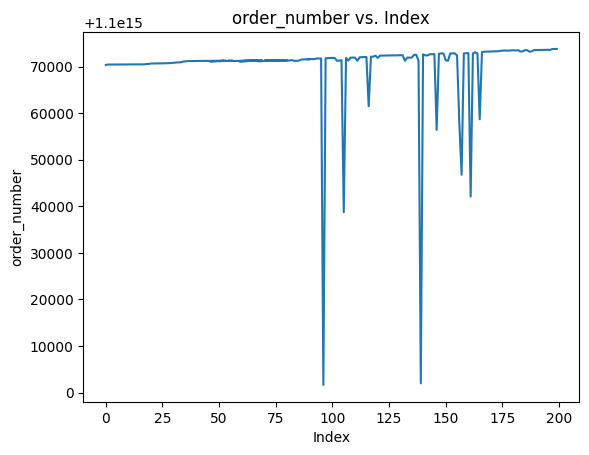

In [89]:
order_20[:200]['order_number'].plot(title='order_number vs. Index')
plt.xlabel('Index')
plt.ylabel('order_number')
plt.show()


In [91]:
order_23 = pd.read_csv(r'c:\Users\Irfan\Hawkes_Modeling\data\outputs\orders\INFY_orders_23082019.csv')
trade_23 = pd.read_csv(r'c:\Users\Irfan\Hawkes_Modeling\data\outputs\trades\INFY_trades_23082019.csv')

In [92]:
trade_23.head()

,record_type,segment,trade_number,symbol,series,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp
0,PO,CASH,2019082325001757,bbbbbbINFY,EQ,796.45,5,1100000000052384,1,3,1100000000054261,1,3,2019-08-23 09:07:23.316421509
1,PO,CASH,2019082325001758,bbbbbbINFY,EQ,796.45,1,1100000000006859,1,1,1100000000054261,1,3,2019-08-23 09:07:23.316436768
2,PO,CASH,2019082325001759,bbbbbbINFY,EQ,796.45,69,1100000000049484,1,3,1100000000054261,1,3,2019-08-23 09:07:23.316452026
3,PO,CASH,2019082325001760,bbbbbbINFY,EQ,796.45,31,1100000000049484,1,3,1100000000021137,1,1,2019-08-23 09:07:23.316467285
4,PO,CASH,2019082325001761,bbbbbbINFY,EQ,796.45,13,1100000000003920,1,3,1100000000021137,1,1,2019-08-23 09:07:23.316482544


In [93]:
order_23.head()

,record_type,segment,order_number,side,activity_type,symbol,series,volume_disclosed,volume,limit_price,trigger_price,is_market_order,is_stop_loss,is_ioc,algo_indicator,client_type,timestamp,is_buy
0,PO,CASH,1100000000001581,SELL,ENTRY,bbbbbbINFY,EQ,0,49,810.0,0.0,False,N,False,1,3,2019-08-23 09:00:00.130279541,False
1,PO,CASH,1100000000001630,BUY,ENTRY,bbbbbbINFY,EQ,0,1,775.0,0.0,False,N,False,1,3,2019-08-23 09:00:00.132232666,True
2,PO,CASH,1100000000001854,SELL,ENTRY,bbbbbbINFY,EQ,0,100,800.0,0.0,False,N,False,1,3,2019-08-23 09:00:00.141967773,False
3,PO,CASH,1100000000001887,SELL,ENTRY,bbbbbbINFY,EQ,0,10,809.0,0.0,False,N,False,1,3,2019-08-23 09:00:00.142959595,False
4,PO,CASH,1100000000001822,SELL,ENTRY,bbbbbbINFY,EQ,0,15,816.0,0.0,False,N,False,1,3,2019-08-23 09:00:00.149688721,False


In [95]:
len(order_23), len(trade_23)

(1313000, 151009)

In [96]:
trade_23 = trade_23[trade_23['record_type'] == 'RM']
order_23 = order_23[order_23['record_type'] == 'RM']

In [97]:
len(order_23), len(trade_23)

(1310925, 150857)

In [126]:
orders_entry = order_23[order_23['activity_type'] == 'ENTRY'].copy()
# orders_entry = order_23.copy()

In [127]:
len(orders_entry)

283899

In [128]:
orders_ts = orders_entry.drop_duplicates('order_number').set_index('order_number')['timestamp']

In [129]:
len(orders_ts)

281885

In [130]:
trade_23['buy_entry_ts'] = trade_23['buy_order_number'].map(orders_ts)
trade_23['sell_entry_ts'] = trade_23['sell_order_number'].map(orders_ts)

In [131]:
buy_missing = trade_23['buy_entry_ts'].isna().sum()
sell_missing = trade_23['sell_entry_ts'].isna().sum()
both_missing = (trade_23['buy_entry_ts'].isna() & trade_23['sell_entry_ts'].isna()).sum()

In [132]:
buy_missing, sell_missing, both_missing

(np.int64(10317), np.int64(10366), np.int64(9205))

In [133]:
def get_aggressor(row):
    """
    Determine aggressor side for a single trade row.
    
    Returns:
        +1: Buyer initiated (buy order arrived later, crossed the spread)
        -1: Seller initiated (sell order arrived later, crossed the spread)
            0: Unknown or simultaneous
    """
    buy_ts = row['buy_entry_ts']
    sell_ts = row['sell_entry_ts']
    
    buy_present = pd.notna(buy_ts)
    sell_present = pd.notna(sell_ts)
    
    if buy_present and sell_present:
        # Both orders found in order file - compare timestamps
        if buy_ts > sell_ts:
            # Buy order arrived AFTER sell order
            # Sell order was resting (passive), buy order crossed the spread (active)
            return 1  # Buyer initiated
        elif sell_ts > buy_ts:
            # Sell order arrived AFTER buy order
            # Buy order was resting (passive), sell order crossed the spread (active)
            return -1  # Seller initiated
        else:
            # Same timestamp - extremely rare but theoretically possible
            # Cannot determine aggressor
            return 0
    elif buy_present and not sell_present:
        # Only buy order found in order file
        # This means buy arrived first (passive), sell arrived later but not recorded
        # Sell order is the aggressor
        return -1  # Seller initiated
    elif not buy_present and sell_present:
        # Only sell order found in order file
        # This means sell arrived first (passive), buy arrived later but not recorded
        # Buy order is the aggressor
        return 1  # Buyer initiated
    else:
        # Both missing from order file - cannot determine
        return 0

In [134]:
trade_23['aggressor_side'] = trade_23.apply(get_aggressor, axis=1)

In [135]:
trade_23['aggressor_side'].value_counts()

aggressor_side
-1    76709
 1    64938
 0     9210
Name: count, dtype: int64

In [136]:
trade_23  = trade_23[trade_23['aggressor_side'] != 0]

In [138]:
trade_23.reset_index(drop=True, inplace=True)

In [139]:
trade_23.head()

,record_type,segment,trade_number,symbol,series,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side
0,RM,CASH,2019082325005679,bbbbbbINFY,EQ,796.0,1,1100000000002865,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006668091,NaN,2019-08-23 09:15:00.005950928,1
1,RM,CASH,2019082325005680,bbbbbbINFY,EQ,796.0,1,1100000000003005,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006683350,NaN,2019-08-23 09:15:00.005950928,1
2,RM,CASH,2019082325005681,bbbbbbINFY,EQ,796.0,2,1100000000003609,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006698608,NaN,2019-08-23 09:15:00.005950928,1
3,RM,CASH,2019082325005682,bbbbbbINFY,EQ,796.0,25,1100000000034715,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006713867,NaN,2019-08-23 09:15:00.005950928,1
4,RM,CASH,2019082325005683,bbbbbbINFY,EQ,796.0,5,1100000000042711,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006729126,NaN,2019-08-23 09:15:00.005950928,1


In [141]:
data['timestamp'].is_monotonic_increasing

True

In [142]:
date_formatted = pd.to_datetime('23082019', format='%d%m%Y').strftime('%Y-%m-%d')
trade_23['date'] = date_formatted

In [143]:
trade_23.shape

(141647, 18)

In [145]:
trade_23.drop(['series', 'symbol', 'segment', 'record_type'], axis=1, inplace=True)

In [146]:
trade_23.shape

(141647, 14)

In [144]:
data.shape

(1362358, 14)

In [149]:
1362358 + 141647

1504005

In [ ]:
trade_23['timestamp'].dtype

dtype('O')

In [153]:
trade_23['timestamp'] = pd.to_datetime(trade_23['timestamp'], errors='coerce')

In [154]:
trade_23['timestamp'].dtype

dtype('<M8[ns]')

In [152]:
data['timestamp'].dtype

dtype('<M8[ns]')

In [155]:
analysis_df = pd.concat([data, trade_23])
analysis_df.sort_values(by='timestamp', inplace=True)
analysis_df.reset_index(drop=True, inplace=True)

In [156]:
analysis_df.head()

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
0,2019081325008066,785.0,1,1100000000068964,1,2,1100000000062580,1,3,2019-08-13 09:15:00.006118774,2019-08-13 09:15:00.005767822,NaT,-1,2019-08-13
1,2019081325008128,785.0,2,1100000000069441,1,3,1100000000062580,1,3,2019-08-13 09:15:00.024169922,2019-08-13 09:15:00.024139404,NaT,-1,2019-08-13
2,2019081325008129,785.0,47,1100000000069442,1,3,1100000000062580,1,3,2019-08-13 09:15:00.024230957,2019-08-13 09:15:00.024215698,NaT,-1,2019-08-13
3,2019081325008130,785.0,53,1100000000069442,1,3,1100000000068983,0,3,2019-08-13 09:15:00.024246216,2019-08-13 09:15:00.024215698,2019-08-13 09:15:00.005935669,1,2019-08-13
4,2019081325008466,785.0,10,1100000000055032,1,3,1100000000070554,0,1,2019-08-13 09:15:00.118347168,NaT,2019-08-13 09:15:00.118331909,1,2019-08-13


In [158]:
len(analysis_df[analysis_df['aggressor_side'] == 0])

32

In [159]:
analysis_df.describe(include='all')

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
count,1.504005e+06,1.504005e+06,1.504005e+06,1.504005e+06,1.504005e+06,1.504005e+06,1.504005e+06,1.504005e+06,1.504005e+06,1504005,1501230,1500765,1.504005e+06,1504005
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520090,496288,NaN,10
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-20 10:24:59.485458374,2019-08-13 15:15:00.468292236,NaN,2019-08-27
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544,501,NaN,241614
mean,2.019082e+15,7.872812e+02,4.610291e+01,1.100000e+15,3.927234e-01,1.869154e+00,1.100000e+15,3.451305e-01,1.706678e+00,2019-08-20 23:59:06.605342720,NaN,NaN,-4.724053e-03,NaN
min,2.019081e+15,7.601500e+02,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,2019-08-13 09:15:00.006118774,NaN,NaN,-1.000000e+00,NaN
25%,2.019082e+15,7.760000e+02,3.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,2019-08-16 11:57:55.080322304,NaN,NaN,-1.000000e+00,NaN
50%,2.019082e+15,7.870000e+02,1.000000e+01,1.100000e+15,0.000000e+00,1.000000e+00,1.100000e+15,0.000000e+00,1.000000e+00,2019-08-21 11:15:42.594421504,NaN,NaN,-1.000000e+00,NaN
75%,2.019083e+15,7.983500e+02,3.600000e+01,1.100000e+15,1.000000e+00,3.000000e+00,1.100000e+15,1.000000e+00,3.000000e+00,2019-08-26 09:22:09.871230976,NaN,NaN,1.000000e+00,NaN
max,2.019083e+15,8.099500e+02,1.265890e+05,1.100000e+15,3.000000e+00,3.000000e+00,1.100000e+15,3.000000e+00,3.000000e+00,2019-08-27 15:59:58.151748657,NaN,NaN,1.000000e+00,NaN


In [160]:
analysis_df = analysis_df[analysis_df['aggressor_side'] != 0]

In [161]:
len(analysis_df)

1503973

In [162]:
analysis_df['timestamp'].is_monotonic_increasing

True

In [164]:
analysis_df[analysis_df['date'] == '2019-08-23']

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
979412,2019082325005679,796.0,1,1100000000002865,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006668091,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
979413,2019082325005680,796.0,1,1100000000003005,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006683350,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
979414,2019082325005681,796.0,2,1100000000003609,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006698608,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
979415,2019082325005682,796.0,25,1100000000034715,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006713867,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
979416,2019082325005683,796.0,5,1100000000042711,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006729126,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121054,2019082328769735,801.0,10,1100000009268743,1,3,1100000007083495,1,3,2019-08-23 15:29:49.621948242,NaN,2019-08-23 13:48:33.193603516,1,2019-08-23
1121055,2019082328770442,800.5,10,1100000008639120,1,3,1100000009270405,0,2,2019-08-23 15:29:54.279724121,2019-08-23 15:01:46.643264771,NaN,-1,2019-08-23
1121056,2019082328770546,801.2,3,1100000009270524,1,3,1100000008690551,1,3,2019-08-23 15:29:55.100036621,NaN,2019-08-23 15:03:58.063980103,1,2019-08-23
1121057,2019082328770547,801.2,10,1100000009270524,1,3,1100000001624312,1,3,2019-08-23 15:29:55.100051880,NaN,2019-08-23 09:48:06.497390747,1,2019-08-23


In [165]:
trade_23

,trade_number,trade_price,volume,buy_order_number,buy_algo,buy_client,sell_order_number,sell_algo,sell_client,timestamp,buy_entry_ts,sell_entry_ts,aggressor_side,date
0,2019082325005679,796.0,1,1100000000002865,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006668091,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
1,2019082325005680,796.0,1,1100000000003005,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006683350,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
2,2019082325005681,796.0,2,1100000000003609,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006698608,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
3,2019082325005682,796.0,25,1100000000034715,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006713867,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
4,2019082325005683,796.0,5,1100000000042711,1,3,1100000000059179,1,3,2019-08-23 09:15:00.006729126,NaN,2019-08-23 09:15:00.005950928,1,2019-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141642,2019082328769735,801.0,10,1100000009268743,1,3,1100000007083495,1,3,2019-08-23 15:29:49.621948242,NaN,2019-08-23 13:48:33.193603516,1,2019-08-23
141643,2019082328770442,800.5,10,1100000008639120,1,3,1100000009270405,0,2,2019-08-23 15:29:54.279724121,2019-08-23 15:01:46.643264771,NaN,-1,2019-08-23
141644,2019082328770546,801.2,3,1100000009270524,1,3,1100000008690551,1,3,2019-08-23 15:29:55.100036621,NaN,2019-08-23 15:03:58.063980103,1,2019-08-23
141645,2019082328770547,801.2,10,1100000009270524,1,3,1100000001624312,1,3,2019-08-23 15:29:55.100051880,NaN,2019-08-23 09:48:06.497390747,1,2019-08-23


In [166]:
analysis_df.to_csv('../data/hawkes_analysis_data.csv', index=False)